In [15]:
print('Meu nome é: Gabriel Moraes Barros ')
print('Meu RA é: 192801')

Meu nome é: Gabriel Moraes Barros 
Meu RA é: 192801


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import sys
import numpy as np
import numpy.random as nr

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

print('Keras ', keras.__version__)

In [ ]:
import os
os.makedirs('../models', exist_ok=True)
nr.seed(20170603)

In [ ]:
!ls ../utils

In [ ]:
sys.path.append('../utils')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter, train_network)


### Testa se um modulo foi importado

In [ ]:
'my_keras_utilities' in sys.modules



try:
    train_network(model_week05, model_name, train_generator, validation_generator, **fit_params);
except AttributeError:
      print('nope')

In [ ]:
import keras.backend as K
K.set_image_data_format('channels_first')
K.set_floatx('float32')
print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
!nvidia-smib

In [ ]:
!ls ../Task\ 5

## Função auxiliar

class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, train_generator, validation_generator, 
                  train_steps=10, valid_steps=10, opt='rmsprop', nepochs=50, 
                  patience=50, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = [ModelCheckpoint(model_file, monitor='val_acc', verbose=0, save_best_only=True, mode='auto', period=1),
        MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=7, verbose=0, mode='auto', epsilon=0.00001, cooldown=0, min_lr=0)
     ]
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb[1].get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs ...".format(tr_epochs))
    try:
        model.fit_generator(train_generator, steps_per_epoch=train_steps,
                            validation_data=validation_generator, validation_steps=valid_steps,
                            epochs=nepochs, verbose=vv, callbacks=[cb[1]])
    except KeyboardInterrupt:
        pass

    model, histo = load_model_and_history(model_name)
    return model, cb


def test_network(model_name, validation_generator, nb_validation_samples):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate_generator(validation_generator, nb_validation_samples)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## Subindo o dataset

In [ ]:
#auternar o comentário, se estiver no client ou no remote
data = np.load('/etc/jupyterhub/ia368z_2s2017/datasets/cifar10-redux.npz')
#data = np.load('../Task 5/cifar10-redux.npz')

In [ ]:
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

In [ ]:
X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype

### Separando o conjunto de treinamento em validação e treinamento, numa proporção 80/20 %


In [ ]:
p=np.random.permutation(len(X_train))
percent_factor=0.85
new_train_x = X_train[p]
new_train_y = y_train[p]


new_X_train = new_train_x[0:(np.floor(len(new_train_x)*percent_factor))]
new_y_train = new_train_y[0:(np.floor(len(new_train_y)*percent_factor))]
new_X_val = new_train_x[(np.ceil(len(new_train_x)*percent_factor)):]
new_y_val = new_train_y[(np.ceil(len(new_train_y)*percent_factor)):]


In [ ]:
print('X_train.shape',new_X_train.shape)
print('y_train.shape',new_y_train.shape)
print('X_val.shape',new_X_val.shape)
print('y_val.shape',new_y_val.shape)
print('y_test shape ',y_test.shape)
print('X_test.shape:',X_test.shape)


In [ ]:
print('Número de diferentes classes',len(np.unique(y_test)))


Normalizando os dados

In [ ]:
a=0
print(np.mean(X_train))

#Guaranteeing that it only runs once
if (a==0):
    X_test = X_test.astype('float32')
    new_X_train = new_X_train.astype('float32')
    new_X_val = new_X_val.astype('float32')
    
    new_X_val /= 255.
    new_X_train /= 255.
    X_test /= 255.
    
    a=1
print(np.mean(new_X_train))
print(np.mean(new_X_val))
print(np.mean(X_test))

In [ ]:
from keras.utils import np_utils

## Transforma o vetor de labels para o formato de one-hot encoding.
n_classes = 3
y_train_oh = np_utils.to_categorical(new_y_train-3, n_classes)
y_val_oh = np_utils.to_categorical(new_y_val-3, n_classes)
y_test_oh = np_utils.to_categorical(y_test-3, n_classes)

In [ ]:
print(y_train_oh.shape)
print(y_val_oh.shape)
print(y_test_oh.shape)


## Fazendo o data augmentation

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
print('new x train shape', new_X_train.shape)
print('y train oh shape', y_train_oh.shape)

print('new x val shape', new_X_val.shape)
print('y val oh shape', y_val_oh.shape)



In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
nb_train_samples = new_train_x.shape[0]
nb_val_samples = new_X_val.shape[0]
print('nb val samples',nb_val_samples)
nb_test_samples = X_test.shape[0]

# dimensions of our images.
img_width, img_height = 32, 32
batch_size=100

In [ ]:
# this is the augmentation configuration we will use for training
aug_datagen = ImageDataGenerator(
       rescale=1./255,         # sempre faz o rescale
       shear_range=0.2,        # sorteio entre 0 e 0.2 distribuição uniforme
       zoom_range=0.2,         # sorteio entre 0 e 0.2
       horizontal_flip=True)   # sorteio 50%

non_aug_datagen = ImageDataGenerator( rescale=1./255)

In [ ]:
train_generator = aug_datagen.flow(
        x = new_X_train, y = y_train_oh,                       # as amostras de treinamento
        batch_size=batch_size,shuffle=False                # batch size do SGD
        )

validation_generator = non_aug_datagen.flow(
        x = new_X_val, y = y_val_oh,                  # as amostras de validação
        batch_size=batch_size, shuffle = False)

In [ ]:
test_generator = non_aug_datagen.flow(
        x = X_test, y = y_test_oh,                  # as amostras de validação
        batch_size=batch_size, shuffle = False)

#Conjunto de treinaemnto
samples_train = train_datagen.flow(new_X_train)
n_samples_train = nb_train_samples/batch_size

#Conjunto de teste
samples_test = train_datagen.flow(X_test)
n_samples_test = nb_test_samples/batch_size
#Conjunto de validacao

samples_val = train_datagen.flow(new_X_val)
n_samples_val = nb_val_samples/batch_size

In [ ]:
n_classes = len(np.unique(y_test))
print(n_classes)

## Treinamento

# Transfer_Learning


## Subindo a VGG-16

In [ ]:
print(y_train_oh.shape)

In [ ]:
from keras.applications.vgg16 import VGG16
#modelvgg = VGG16(include_top=False, weights='imagenet',classes=y_train_oh.shape[1])
modelvgg = VGG16(include_top=False, weights='imagenet')


modelvgg.layers = modelvgg.layers[:-4]
modelvgg.summary()

In [14]:
train_generator.n

NameError: name 'train_generator' is not defined

In [27]:
train_feature = modelvgg.predict_generator(generator=train_generator, steps=int(np.round(train_generator.n / batch_size)))
print(train_feature.shape, train_feature.dtype)
validation_features = modelvgg.predict_generator(generator = validation_generator, steps=int(np.round(validation_generator.n / batch_size)))
print(validation_features.shape, validation_features.dtype)
test_features = modelvgg.predict_generator(generator = test_generator, steps=int(np.round(test_generator.n / batch_size)))
print(test_features.shape, test_features.dtype)



(1700, 512, 1, 1) float32
(300, 512, 1, 1) float32
(500, 512, 1, 1) float32


In [28]:
print(train_feature.shape)

(1700, 512, 1, 1)


In [29]:
train_feature.shape[1]

512

In [30]:

def model_build():
    model = Sequential()
    model.add(Flatten(input_shape=(train_feature.shape[1:])))
    model.add(Dense(256, activation='relu'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
    return model
n_classes=3
model = model_build()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 132,099
Trainable params: 132,099
Non-trainable params: 0
_________________________________________________________________


In [31]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, Xtra, ytra, Xval, yval, 
                  opt='rmsprop', batch_size=100, nepochs=50, patience=50, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs ...".format(tr_epochs))
    try:
         model.fit(Xtra, ytra, batch_size=batch_size, epochs=tr_epochs, verbose=vv, 
                      validation_data=(Xval,yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass

    model, histo = load_model_and_history(model_name)
    return model, cb


def test_network(model_name, Xtest, ytest, batch_size=40):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(Xtest, ytest, batch_size=batch_size, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))

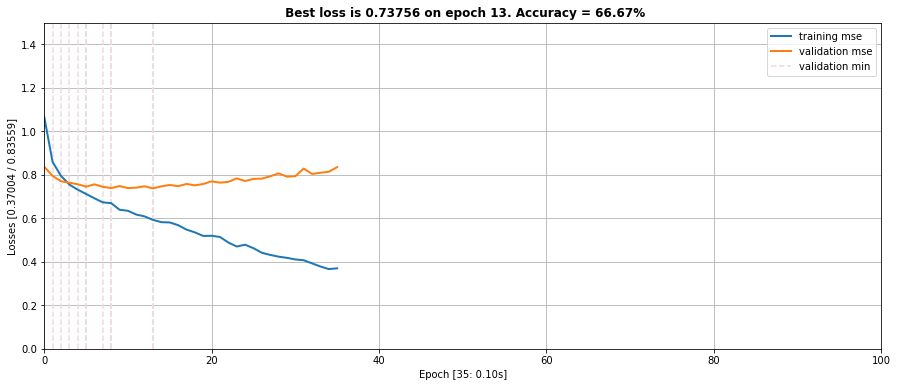

In [32]:

fit_params = {
    'opt':         'adam',           # SGD(lr=0.01, momentum=0.9, nesterov=True), 
    'nepochs':         100, 
    'patience':        30,
    'ploss':           1.5,
    'reset':           True,
}
model_name = 'whatevah'
train_network(model, model_name, train_feature, y_train_oh, validation_features, y_val_oh,  **fit_params);


In [34]:
loss, accuracy = model.evaluate(test_features, y_test_oh, batch_size=batch_size)
print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))

100/500 [=====>........................] - ETA: 0s
[INFO] accuracy on the test data set: 66.80% [0.80362]


## Agora vamos carregar estes pesos para um mesmo modelo colado em uma VGG

### Replique o modelo

In [35]:
model.save_weights('../model1_model_weights.h5')


In [36]:
model2 = model

In [37]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 132,099
Trainable params: 132,099
Non-trainable params: 0
_________________________________________________________________


In [4]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model, Input
#vgg = VGG16(include_top=False, weights='imagenet')

modelvgg2 =  VGG16(include_top=False, weights='imagenet')
modelvgg2.layers = modelvgg2.layers[:-4]
input = Input(shape=(3, 32, 32))
print(modelvgg2.outputs)

[<tf.Tensor 'block5_pool_3/MaxPool:0' shape=(?, ?, ?, 512) dtype=float32>]


In [12]:
def model_vgg_create(modelvgg2):
    input = Input(shape=(3, 32, 32))
    modelvgg2.trainable = False
    x = modelvgg2(input)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(3, activation='softmax')(x)
    
    model2 = Model(inputs=input, outputs=output)
    return model2

In [13]:
model_bottom = model_vgg_create(modelvgg2)

ValueError: number of input channels does not match corresponding dimension of filter, 32 != 3

In [ ]:
vgg = VGG16(include_top=False, weights='imagenet')
#vgg.summary()
for k,layer in enumerate(vgg.layers):
    if k>10:
        print(k, layer.name)

input = Input(shape=(3, 32, 32))
print(vgg.outputs)

In [58]:
modelvgg2.output.shape

TensorShape([Dimension(None), Dimension(512)])

In [59]:
del meio

In [60]:
print(train_feature.shape[1:])
meio = modelvgg2.output

(512, 1, 1)


In [61]:
meio = Dense(512,activation='relu')(meio)

In [63]:
model_meio = Model(inputs=modelvgg2.input, outputs=meio)


In [64]:
model_final = Model(inputs=model_meio.output, outputs = model2.output)

/home/adessowiki/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:1562: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "model_4" was not an Input tensor, it was generated by layer dense_11.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: dense_11/Relu:0
  str(x.name))


TypeError: Input layers to a `Model` must be `InputLayer` objects. Received inputs: Tensor("dense_11/Relu:0", shape=(?, 512), dtype=float32). Input 0 (0-based) originates from layer type `Dense`.

In [ ]:
x = vgg.output
x = Dense(256, activation='relu', name='d1')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax', name='d2')(x)

In [42]:
model_meio = Model(inputs=modelvgg2.input, outputs=model2.output)


RuntimeError: Graph disconnected: cannot obtain value for tensor Tensor("flatten_1_input:0", shape=(?, 512, 1, 1), dtype=float32) at layer "flatten_1_input". The following previous layers were accessed without issue: []

In [ ]:
model = Model(inputs=vgg.input, outputs=x)

In [38]:
from keras.models import Sequential, Model, load_model


In [39]:
model_somados = Model(inputs=modelvgg.input, outputs=model2.output)
W = model2.load_weights()

RuntimeError: Graph disconnected: cannot obtain value for tensor Tensor("flatten_1_input:0", shape=(?, 512, 1, 1), dtype=float32) at layer "flatten_1_input". The following previous layers were accessed without issue: []

In [ ]:
from keras.applications.vgg16 import VGG16

vgg = VGG16(include_top=False, weights='imagenet', classes=3, pooling = 'max')

# build a classifier model and put on top of the convolutional model
vgg.layers = vgg.layers[:-4]
x = vgg.output
x = Dense(256, activation='relu', name='d1')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax', name='d2')(x)

model = Model(inputs=vgg.input, outputs=x)

#importa o melhor modelo obtido pelo transfer learning (o arquivo que gerou este modelo é ./my_cifar_transferlearning_original.ipynb)
top_model_name = './best_transfer71.model'

# Carrego os pesos treinados anteriormente
w1, b1, w2, b2 = load_model(top_model_name).get_weights()    

# Coloco nas camadas densas finais da rede
model.layers[20].set_weights([w1, b1])
model.layers[22].set_weights([w2, b2])

#set layers from VGG to not be part of the train
for layer in model.layers[:17]:
    layer.trainable = False
    
model.summary()

batch_size=50
epochs = 50

cb = [
      ModelCheckpoint('anything', monitor='val_acc', verbose=0, save_best_only=True, mode='auto', period=1),
      ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
     ]

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

#model.fit_generator(generator        = train_generator,
 #                                     steps_per_epoch  = int(np.round(train_generator.n / batch_size)),
  #                                    validation_data  = validation_generator,
   #                                   validation_steps = int(np.round(validation_generator.n / batch_size)),
    #                                  epochs           = 200,
     #                                 verbose          = 0,
      #                                callbacks=cb)
h = model.fit(train_feature, y_train_oh,
              validation_data=(validation_features, y_test_oh),
              epochs=epochs, batch_size=batch_size, callbacks=cb)



In [ ]:
h = model.fit(train_features, y_train_oh,
              validation_data=(valid_features, y_test_oh),
              epochs=epochs, batch_size=batch_size, callbacks=cb)

In [ ]:
model.fit_generator(generator        = gen_train,
                                      steps_per_epoch  = int(np.round(gen_train.n / batch_size)),
                                      validation_data  = gen_valid,
                                      validation_steps = int(np.round(gen_valid.n / batch_size)),
                                      epochs           = 2000,
                                      verbose          = 2,
                                      callbacks=[checkpoint])

In [ ]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)

fit_params = {
    'train_steps':     nb_train_samples / batch_size,
    'valid_steps':     nb_val_samples / batch_size,
    'opt':             'adam',    # SGD(lr=0.1, momentum=0.9, nesterov=True), 
    'nepochs':         100, 
    'patience':        15,
    'ploss':           1.0,
    'reset':           False,
}

model_name = 'week05'

gen_train,
                                      steps_per_epoch  = int(np.round(gen_train.n / batch_size)),
                                      validation_data  = gen_valid,
                                      validation_steps = int(np.round(gen_valid.n / batch_size)),
                                      epochs           = 2000,
                                      verbose          = 2,
                                      callbacks=[checkpoint])
                        
                        
train_network(model, model_name, train_generator, validation_generator, **fit_params);

In [ ]:
    # Aqui os features deixam de ser imagens
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Activation('softmax'))

In [ ]:
train_feature.shape

topmodel.summary()

modelvgg.summary()

In [ ]:
train_feature.shape[1:]
train_feat = train_feature.reshape(1700,512)
print(train_feat.shape)

In [ ]:
modelvgg.output

In [ ]:
def model_build():
    img_rows, img_cols = 32, 32 # Dimensões das imagens
    #imagens com 3 canais e 32x32
    input_shape = (3, img_rows, img_cols)

    # Definindo a rede
    model = Sequential()
    #primeira conv
    model.add(Conv2D(32, (3, 3),
                     input_shape=input_shape))
    model.add(Activation('relu'))
    
    #segunda conv
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # Aqui os features deixam de ser imagens
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
    return model
model_week05 = model_build()

In [ ]:
model_week05.load_weights('../my_cifar_dataplus_model_weights.h5')
print("done")

In [ ]:
model_week05.summary()

In [ ]:
print(model_week05.layers)
print(len(model_week05.layers))
weights10 = model_week05.layers[10].get_weights()
print(weights10[0].shape,weights10[1].shape)
weights7 = model_week05.layers[7].get_weights()
print(weights7[0].shape,weights7[1].shape)


In [ ]:
w2, b2 = weights10
w1, b1 = weights7


In [ ]:
topmodel = Sequential()
topmodel.add(layer=keras.layers.Flatten(input_shape=(1,1,512)))
# topmodel.add(layer=keras.layers.Dense(units=256, activation='relu', name='d256'))

topmodel.add(layer=keras.layers.Dense(units=128, name='d256',))
topmodel.add(Activation('relu'))
topmodel.add(layer=keras.layers.Dropout(rate=.5))
topmodel.add(layer=keras.layers.Dense(units=3, name='d3'))
topmodel.add(Activation('softmax'))
# topmodel.compile(optimizer=keras.optimizers.SGD(lr=.05, momentum=.9, nesterov=True),
topmodel.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [ ]:
topmodel.summary()

In [ ]:
print(topmodel.layers)
print(len(topmodel.layers))

In [ ]:
topmodel.layers[20].set_weights([w1, b1])
topmodel.layers[5].set_weights([wei])

In [ ]:
!ls ../

w1, b1, w2, b2 = load_model('../my_cifar_dataplus_model_weights.h5').get_weights()   

w1, b1, w2, b2 = load_model('../my_cifar_dataplus_model_weights').get_weights()m m  mmm

In [ ]:
model2.load_weights('../my_cifar_dataplus_model_weights.h5')



    # Aqui os features deixam de ser imagens
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation('softmax'))

topmodel = Sequential()
# topmodel.add(layer=keras.layers.Flatten(input_shape=feat_train.shape[1:]))
# topmodel.add(layer=keras.layers.Dense(units=256, activation='relu', name='d256'))
topmodel.add(layer=keras.layers.Dense(units=256, activation='relu', name='d256', input_shape=(1,1,512)))
topmodel.add(layer=keras.layers.Dropout(rate=.5))
topmodel.add(layer=keras.layers.Dense(units=3, activation='softmax', name='d3'))

# topmodel.compile(optimizer=keras.optimizers.SGD(lr=.05, momentum=.9, nesterov=True),
topmodel.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

#train_features = modelvgg.predict(new_X_train)
train_features = modelvgg.predict(new_X_train)

print('train_features shape and type',train_features.shape,train_features.dtype)
validation_features = modelvgg.predict(new_X_val)
print('validation_features shape and type',validation_features.shape,train_features.dtype)
test_features = modelvgg.predict(X_test)
print('test_features shape and type',test_features.shape,train_features.dtype)

In [ ]:
modelvgg.layers.pop(18)
modelvgg.layers.pop(17)
modelvgg.layers.pop(16)
modelvgg.layers.pop(15)

In [ ]:
#modelvgg.summary()

In [ ]:
train_features = modelvgg.predict(new_X_train)
print('train_features shape and type',train_features.shape,train_features.dtype)
validation_features = modelvgg.predict(new_X_val)
print('validation_features shape and type',validation_features.shape,train_features.dtype)
test_features = modelvgg.predict(X_test)
print('test_features shape and type',test_features.shape,train_features.dtype)

In [ ]:
train_features.shape[1:]

In [ ]:
model_name = '../cifar_redux_augmented_vgg'

modelVGG = Sequential()
modelVGG.add(Flatten(input_shape= train_features.shape[1:]))    
modelVGG.add(Dense(120))
modelVGG.add(Activation('relu'))
modelVGG.add(Dropout(0.5))
modelVGG.add(Dense(3))
modelVGG.add(Activation('softmax'))

In [ ]:
modelVGG.summary()

## Treinando class MyCb(TrainingPlotter):
    

In [ ]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, Xtra, ytra, Xval, yval, 
                  opt='rmsprop', batch_size=100, nepochs=50, patience=50, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs ...".format(tr_epochs))
    try:
         model.fit(Xtra, ytra, batch_size=batch_size, epochs=tr_epochs, verbose=vv, 
                      validation_data=(Xval,yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass

    model, histo = load_model_and_history(model_name)
    return model, cb


def test_network(model_name, Xtest, ytest, batch_size=40):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(Xtest, ytest, batch_size=batch_size, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))

In [ ]:
print('train_features.shape',train_features.shape)
print('validation_features.shape',validation_features.shape)
print('test_features.shape',test_features.shape)



In [ ]:
fit_params = {
    'opt':         'adam',           # SGD(lr=0.01, momentum=0.9, nesterov=True), 
    'nepochs':         100, 
    'patience':        30,
    'ploss':           1.5,
    'reset':           True,
}

train_network(modelVGG, model_name, train_features, y_train_oh, validation_features, y_val_oh,  **fit_params);

In [ ]:
test_network(model_name, test_features,y_test_oh,X_test.shape[0])

In [ ]:
from keras.applications.vgg16 import VGG16

print("[INFO] creating model...")
#vgg = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
vgg = VGG16(include_top=False, weights='imagenet')
vgg.summary()

## Construção da rede neural

In [ ]:
print(train_features.shape)
print(new_X_train.shape)

In [ ]:
img_height, img_width = new_X_train.shape[2],new_X_train.shape[3]
print(img_height,img_width)

In [ ]:
!ls ..

In [ ]:
from keras.models import Model
from keras.models import load_model

model_name = '../cifar10_vgg_finetune'   # modelo da rede atual
top_model_name = '../cifar_redux_augmented_vgg'
nb_classes=3

In [ ]:
model = Model(inputs=vgg.input, outputs=x)

In [ ]:
def build_net(top_model_name):
    from keras.applications.vgg16 import VGG16
    
    print("[INFO] creating model...")
    #vgg = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
    #vgg = VGG16(include_top=False, weights='imagenet', input_shape=(3,img_height, img_width))
    vgg = VGG16(include_top=False, weights='imagenet', classes=nb_classes, pooling='max')
    
    print(vgg.output)
    # build a classifier model and put on top of the convolutional model
    #x = Flatten()(vgg.output)
    x = Dense(120, activation='relu', name='dense1')(vgg.output)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='relu', name='d1')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid', name='d2')(x)
    
    #x = Dense(40, activation='relu', name='dense1')(vgg.output)
   # x = Dropout(0.5)(x)
    #x = Dense(120, activation='relu', name='dense2')(x)
    #x = Dropout(0.2)(x)
    #x = Dense(nb_classes, activation='softmax', name='dense3')(x)

    #model = Model(inputs=vgg.input, outputs=x
    
    
    model = Model(inputs=vgg.input, outputs=x)
    print(model.layers)
    print(len(model.layers))    #     print('Model layers:')
    #     for i, layer in enumerate(model.layers):
    #         print('    {:2d} {:15s} {}'.format(i, layer.name, layer))
    
    # modelo da rede densa treinada no notebook anterior
    top_model_name = top_model_name
    # Carrego os pesos treinados anteriormente
    #w1, b1, w2, b2 = load_model(top_model_name).get_weights()    
    w1, b1, w2, b2 = modelVGG.get_weights()    
    print(w1.shape,b1.shape,w2.shape,b2.shape)
    # Coloco nas camadas densas finais da rede
    model.layers[20].set_weights([w1, b1])
    model.layers[22].set_weights([w2, b2])
    
    # Torno não-treináveis as primeiras 15 camadas
    # da rede (os pesos não serão alterados)
    for layer in model.layers[:15]:
        layer.trainable = False
        
    return model

model = build_net(top_model_name)

In [ ]:
#model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
batch_size = 40

In [ ]:
print(new_X_train.shape, y_train_oh.shape,new_X_val.shape, y_val_oh.shape)

(1600, 32, 32, 3) (1600, 3) (400, 32, 32, 3) (400, 3)


In [ ]:
h = model.fit(new_X_train.reshape(1700,3,32,32), y_train_oh,
              validation_data=(new_X_val.reshape(300,3,32,32), y_val_oh),
              batch_size=batch_size,
              epochs=100,
              )

In [ ]:
h = model.fit(X_train[train_i], y_train_oh[train_i],
              validation_data=(X_train[val_i], y_train_oh[val_i]),
              batch_size=batch_size,
              epochs=400,
              callbacks=[early_stopping, checkpointer, reduce_lr], verbose=1)

In [ ]:

model_name = '../cifar10_vgg_finetune'
fit_params = {
    'opt':         'adam',           # SGD(lr=0.01, momentum=0.9, nesterov=True), 
    'nepochs':         100, 
    'patience':        30,
    'ploss':           1.5,
    'reset':           True,
}

train_network(model, model_name, train_features, y_train_oh, validation_features, y_val_oh,  **fit_params);